# CNN 설계


In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torchvision.utils import make_grid
import os
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


In [3]:
!pip install kaggle --upgrade
os.environ['KAGGLE_USERNAME'] = 'jungyuchoi'
os.environ['KAGGLE_KEY'] = '9431599f2458bdba977477e62d1dd272'
!kaggle datasets download -d ananthu017/emotion-detection-fer
!unzip '*.zip'


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/sad/im37.png      
  inflating: train/sad/im370.png     
  inflating: train/sad/im3700.png    
  inflating: train/sad/im3701.png    
  inflating: train/sad/im3702.png    
  inflating: train/sad/im3703.png    
  inflating: train/sad/im3704.png    
  inflating: train/sad/im3705.png    
  inflating: train/sad/im3706.png    
  inflating: train/sad/im3707.png    
  inflating: train/sad/im3708.png    
  inflating: train/sad/im3709.png    
  inflating: train/sad/im371.png     
  inflating: train/sad/im3710.png    
  inflating: train/sad/im3711.png    
  inflating: train/sad/im3712.png    
  inflating: train/sad/im3713.png    
  inflating: train/sad/im3714.png    
  inflating: train/sad/im3715.png    
  inflating: train/sad/im3716.png    
  inflating: train/sad/im3717.png    
  inflating: train/sad/im3718.png    
  inflating: train/sad/im3719.png    
  inflating: train/sad/im372.png     
  inflating: train/sad/im3720.png    
  inflating: t

In [4]:
!ls
torch.cuda.empty_cache()
import gc

gc.collect()

emotion-detection-fer.zip  sample_data	test  train


114

## 하이퍼파라미터 

In [5]:
EPOCHS     = 20
BATCH_SIZE = 16

## 데이터셋 불러오기

torch.Size([16, 1, 48, 48])
tensor([6, 3, 3, 6, 3, 4, 6, 4, 3, 5, 6, 3, 6, 3, 4, 5])


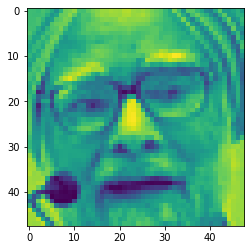

In [13]:
trans = transforms.Compose([
                            transforms.Grayscale(),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,))])

train_data = torchvision.datasets.ImageFolder(root='./train', transform=trans)
test_data = torchvision.datasets.ImageFolder(root='./test', transform=trans)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = True)

classes = ['neutral', 'fearful', 'sad', 'happy', 'surprised', 'angry', 'disgusted']

dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
img = Image.open('./train/angry/im1.png')
plt.imshow(np.asarray(img))
print(labels)

## 모델



In [14]:
# 미리 훈련된 ResNet 모델을 다운로드하고 불러옴
# torchvision.models 참고

import torchvision.models as models

# model = models.resnet50(pretrained=True)
# print(model) # 불러온 모델 구조 확인

class Model(nn.Module):
    def __init__(self):
      super(Model, self).__init__()
      self.conv1 = nn.Conv2d(1, 16, 3)
      self.conv2 = nn.Conv2d(16, 32, 3)
      self.conv3 = nn.Conv2d(32, 64, 3)
      self.conv4 = nn.Conv2d(64, 32, 3)
      self.fc1 = nn.Linear(2048, 1024)
      self.fc2 = nn.Linear(1024, 128)
      self.fc3 = nn.Linear(128, 7)
      self.batch_norm_16 = nn.BatchNorm2d(16)
      self.batch_norm_32 = nn.BatchNorm2d(32)
      self.batch_norm_64 = nn.BatchNorm2d(64)
      self.drop_out = nn.Dropout2d(p=0.3)

    def forward(self, x):
      
      x = F.relu(self.batch_norm_16(self.conv1(x)))
      x = F.relu(self.drop_out(F.max_pool2d(self.batch_norm_32(self.conv2(x)), 2)))
      x = F.relu(self.drop_out(F.max_pool2d(self.batch_norm_64(self.conv3(x)), 2)))
      x = F.relu(self.drop_out(self.batch_norm_32(self.conv4(x))))
      x = x.view(-1, 2048)

      x = F.relu(self.drop_out(self.fc1(x)))
      x = F.relu(self.drop_out(self.fc2(x)))
      x = self.fc3(x)

      return x

model = Model()

In [8]:
# 제일 마지막 FC layer를 Cifar 클래스에 맞도록 Output 크기 교체 == 즉, resnet.fc를 새로운 nn.Linear를 정의하여 할당.
# 기존 ResNet 모델 FC layer의 in_features값을 할당
#num_input을 nn.Linear에 넣고 수정

# model.fc = nn.Linear(model.fc.in_features, 7)

## 준비

In [25]:
model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## 학습하기

In [20]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

## 테스트하기

In [21]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 학습

In [26]:
loss = []
accuracy = []
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    scheduler.step()
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    loss.append(test_loss)
    accuracy.append(test_accuracy)
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))
plt.plot(loss)
plt.plot(accuracy)
plt.ylim(0, 100)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

[1] Test Loss: 1.8143, Accuracy: 24.71%


KeyboardInterrupt: ignored